In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from toolz import *

# Why Prediction Metrics are Dangerous For Causal Models
 
제가 접하는 흔한 잘못 중 하나는 무작위 데이터에 대한 인과 모델을 평가하면서 $R^2$와 같은 지표를 사용하는 것입니다. 하지만 인과 모델 평가는 그렇게 간단하지 않습니다. 왜 그런지 알아봅시다. 대체로 어떠한 결과(`outcome`, $Y$)는 처치(`treatment`, $t$)와 공변량(`covariate`, $x$)의 함수입니다.
 
$$
Y = F(x, t)
$$
 
함수를 둘로 분해할 수 있다고 가정하겠습니다. $F(x, t)$는 처치와 관련 없는 함수 $g(x)$와 처치와 추가적인 교호작용으로 이루어진 함수 $f(t, x)$로 나뉩니다.

$$
Y = g(x) + f(t,x)
$$
 
이러한 형태는 함수 모양을 약간 제한하지만, 그 정도가 크지 않아 데이터 생성 프로세스(Data Generating Process, DGP)를 설명하는 상당히 일반적인 방법이라고 주장할 수 있습니다. 요점은 처치 효과가 공변량 효과보다 약하다면 **무작위 데이터**라도 예측력은 높지만 인과 추론에는 나쁜 모델을 얻을 수 있습니다. 모델은 $f(t,x)$를 무시하며, $g(x)$와 거의 같을 것입니다. **무작위 데이터에 대한 예측 성능은 인과 추론에 얼마나 적합한지 말해주지 않습니다.** 설명을 위해 시뮬레이션 데이터를 사용해 보겠습니다.
 
## Simulating Data
 
예측력은 높지만, 처치와 관련 없는 공변량 $X$가 존재합니다. $X$는 처치 효과의 이질성을 설명하지 않습니다. 또한, 처치를 통해서만 결과에 영향을 주는 $W$가 존재합니다. $W$는 교란자(`confounder`)가 아닙니다. 처치는 예측력이 낮으므로 $W$ 또한 예측력이 높지 않습니다.
 
$$
Y_i = g(X_i) + f(T_i,W_i) + e_i
$$

In [2]:
n = 100000
n_features = 20
n_heter = 10

np.random.seed(12321)

X = np.random.normal(1, 10, (n, n_features))
nuisance = np.random.uniform(-1,1, (n_features, 1))

W = np.random.normal(1, 10, (n, n_heter))
heter_y = np.random.uniform(-1,1, (n_heter, 1))

T = np.random.normal(10, 2, (n, 1)) # T is random!
Y = np.random.normal(T + T*W.dot(heter_y) + 20*X.dot(nuisance), 0.1)

df = pd.concat([
    pd.DataFrame(X, columns=[f"f{f}" for f in range(n_features)]),
    pd.DataFrame(W, columns=[f"w{f}" for f in range(n_heter)])
], axis=1).assign(T=T, Y=Y)

데이터를 훈련 데이터와 테스트 데이터로 나눕니다.

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.5)
train.shape, test.shape

((50000, 32), (50000, 32))

이제 두 모델 $M1$, $M2$를 훈련합니다. $M1$은 처치 이질성과 관련 없는 예측에 뛰어난 변수로 훈련하며, $M2$는 처치 이질성에 미미한 영향을 주는 변수로 훈련합니다.

In [4]:
m1 = smf.ols("Y~T*(" + "+".join([f"f{f}" for f in range(n_features)])+")", data=df).fit()
m2 = smf.ols("Y~T*(" + "+".join([f"w{f}" for f in range(n_heter)])+")", data=df).fit()

$R^2$로 두 모델의 예측력을 확인하면 $M1$이 $M2$보다 훨씬 높습니다.

In [5]:
from sklearn.metrics import r2_score

print("M1:", r2_score(test["Y"], m1.predict(test)))
print("M2:", r2_score(test["Y"], m2.predict(test)))

M1: 0.9160516511287359
M2: 0.08378351037639298


그럼 두 모델에 대한 누적 탄력 곡선을 구해보겠습니다. 이를 위해서 조건부 평균 처치 효과를 예측해야 합니다. 모델은 선형회귀이므로 아래 공식으로 `CATE` 예측값을 얻습니다.

$$
\hat{CATE_i} = M(X, W, t) - M(X, W, t-1)
$$

In [6]:
@curry
def elast(data, y, t):
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))
    

def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([elast(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])


In [7]:
test_pred = test.assign(
    cate_1 = m1.predict(test) - m1.predict(test.assign(T=test["T"]-1)),
    cate_2 = m2.predict(test) - m2.predict(test.assign(T=test["T"]-1))
)

`CATE` 예측값과 함께 누적 탄력 곡선으로 모델을 평가합시다.

In [8]:
cumelast_1 = cumulative_gain(test_pred, "cate_1", "Y", "T", steps=100)
cumelast_2 = cumulative_gain(test_pred, "cate_2", "Y", "T", steps=100)

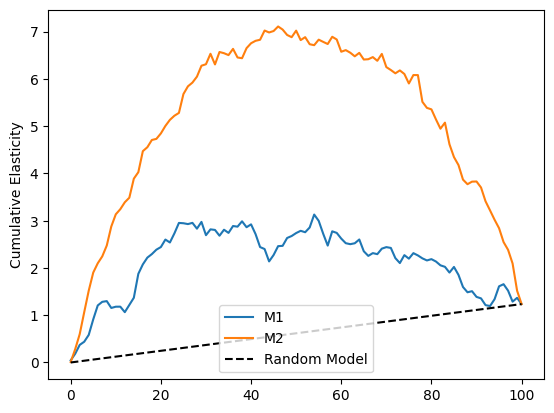

In [9]:
plt.plot(range(len(cumelast_1)), cumelast_1, label="M1")
plt.plot(range(len(cumelast_2)), cumelast_2, label="M2")
plt.plot([0, 100], [0, elast(test_pred, "Y", "T")], linestyle="--", label="Random Model", color="black")
plt.legend()
plt.ylabel("Cumulative Elasticity");

테스트 데이터에서 $M1$은 더 높은 $R^2$를 가지지만, 누적 탄력 곡선은 $M2$보다 훨씬 더 나쁩니다. 무작위 데이터를 사용하더라도 높은 예측 지표는 좋은 인과 모델을 의미하지 않습니다.

## Predictive Metric For Causal Inference
 
예측 지표로 인과 모델을 올바르게 평가할 방법이 있습니다. 데이터 생성 프로세스에 대한 추가 가정을 살펴봅시다.

$$
Y = g(x) + f(t,x)
$$
 
예측 지표를 사용하기 위해서는 $Y$로부터 $g(x)$를 어떻게든 제거해야 합니다. $g(x)$를 없애기만 한다면 모델은 인과관계를 학습할 것입니다.

$$
\tilde{Y} = Y - g(x) = f(t,x)
$$
 
한 가지 방법은 $Y$를 직교화하는 것입니다. 임의의 `ML` 모델로 $g(x)$를 추정하여 제거할 수 있습니다.

$$
\tilde{Y} = Y - \hat{g}(x)
$$

In [10]:
denoise_m = smf.ols("Y~"+
                    "+".join([f"w{f}" for f in range(n_heter)])+
                    "+"+
                    "+".join([f"f{f}" for f in range(n_features)]), data=train).fit()

test_res = test.assign(Y_res = test["Y"] - denoise_m.predict(test) + test["Y"].mean())

직교화를 거친 $\tilde{Y}$에 대한 좋은 예측 성능은 더 나은 인과 모델을 의미합니다.

In [11]:
print("M1:", r2_score(test_res["Y_res"], m1.predict(test_res)))
print("M2:", r2_score(test_res["Y_res"], m2.predict(test_res)))

M1: -281.79501850924754
M2: -24.04912481654566


이 방법은 $g(x)$를 얼마나 잘 추정하는지에 따라 결과가 달라지는 문제가 있습니다.